### Word Topic frequency analysis based on LIWC
- https://python-graph-gallery.com/11-grouped-barplot/

In [113]:
import sklearn
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import gensim
import numpy as np
from matplotlib.ticker import FuncFormatter

import re
from collections import Counter
from pyliwc.core import LIWC

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# package use
import requests
import urllib
import urllib.request
import time
import string
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import json

In [5]:
# read comment frequency file 
comment_frequency = pd.read_csv("comment_frequency_director.csv")
Name_list = comment_frequency.columns.tolist()
Name_list = [item for item in Name_list if 'Unnamed' not in item]
# kick out Unnamed columns for simplicity
comment_frequency = comment_frequency[Name_list]
print("Number of movies to analyze: ", len(comment_frequency))
comment_frequency.head(3)

Number of movies to analyze:  2402


,year,bomrank,remove,bomtitle,imdblink,bomlink,studio,totalusgross$,totaltheater,openingusgross$,...,critic ratings_avg,critic rating_var,user_avg,user_var,critic_ratings_comments,critic_ratings_list,critic_comment_topic_frequency,director,director_race,director_gender
0,2004.0,1.0,NaN,Shrek 2,http://www.imdb.com/title/tt0298148/,http://www.boxofficemojo.com/movies/?id=shrek2...,DW,441226247.0,4223.0,108037878.0,...,75.0,94.4,7.2,2.37960,"Lightning strikes twice, but not as brilliant...",90.0||88.0||80.0||80.0||80.0||75.0||75.0||70.0...,"[['7', '2', '3', '3', '0', '1', '0', '1', '0',...",Kelly Asbury,W,male
1,2004.0,2.0,NaN,Spider-Man 2,http://www.imdb.com/title/tt0316654/,http://www.boxofficemojo.com/movies/?id=spider...,Sony,373585825.0,4166.0,88156227.0,...,83.0,115.2,7.3,2.86249,The pleasure is doubled in Spider-Man 2. Crac...,100.0||100.0||100.0||91.0||90.0||90.0||88.0||8...,"[['8', '6', '2', '0', '0', '2', '2', '0', '2',...",Sam Raimi,W,male
2,2004.0,3.0,NaN,The Passion of the Christ,http://www.imdb.com/title/tt0335345/,http://www.boxofficemojo.com/movies/?id=passio...,NM,370274604.0,3408.0,83848082.0,...,47.0,663.9,7.2,6.34920,"This is not a sermon or a homily, but a visua...",100.0||80.0||80.0||75.0||63.0||63.0||50.0||50....,"[['0', '0', '0', '0', '0', '0', '0', '0', '0',...",Mel Gibson,W,male


In [18]:
len(comment_frequency[comment_frequency['director'].isnull()])

15

In [45]:
print("Number of blank gender: ", len(comment_frequency[comment_frequency['director_gender'].isnull()]))
print("Number of blank race: ", len(comment_frequency[comment_frequency['director_race'].isnull()]))
# find distinct number of directors 
print("Number of unique directors: ", len(comment_frequency['director'].unique()))
print("Unique race in the table: ", comment_frequency['director_race'].unique())
print("Unique gender in the table: ", comment_frequency['director_gender'].unique())

Number of blank gender:  316
Number of blank race:  316
Number of unique directors:  1296
Unique race in the table:  ['W' 'H' 'M' 'A' 'B' nan 'w']
Unique gender in the table:  ['male' 'female' nan]


In [46]:
# female vs male Black vs White vs Asian peole vs Hispanic and Latin
# return sum of frequency of specific topic and specific group of people and average 

# topics list
topics = ['posemo', 'negemo', 'female', 'male', 'insight', 
          'tentat', 'certain', 'differ', 'risk', 'focusfuture']

# Function to extract all the numbers from the given string 
def getNumbers(str): 
    array = re.findall(r'[0-9]+', str) 
    return array 

def statistical_analyze(race_, gender_, topic_, table=comment_frequency, topics_=topics):
    # find subset for minority directors
    # deal with 'W' and 'w' problem here
    if race_ in ["W", "w"]:
        temp_set = table[(table['director_race'] == "W")|(table['director_race'] == "w")]
    # no specific race
    elif race_ == "nan":
        temp_set = table
    # filter out the non-white groups
    elif race_ in["~W", "~w"]:
        temp_set = table[table['director_race'] != "W"]
        temp_set = temp_set[temp_set['director_race'] != "w"]
        temp_set = temp_set[temp_set['director_race'].notnull()]
    else:
        temp_set = table[table['director_race'] == race_]
        
    # filter gender - male or female
    if gender_ == "nan":
        subset = temp_set
    else:
        subset = temp_set[temp_set['director_gender'] == gender_]
    # simply give director proportion analysis
    if topic_ not in topics_:
        return len(subset)
    # find topic index 
    index = topics_.index(topic_)
    
    frequency = 0
    # use not blank subset to calculate
    subset = subset[subset['critic_comment_topic_frequency'].notnull()]
    total_number = len(subset)
    frequency_result_list = subset['critic_comment_topic_frequency'].to_list()
    for i in range(total_number):
        frequency_string = frequency_result_list[i]
        # total single array for all comments for one director
        frequency_array = getNumbers(frequency_string) 
        count = 0
        while count < len(frequency_array)/len(topics_):
            frequency += int(frequency_array[index+count*len(topics_)])
            count += 1
    return total_number, frequency

In [47]:
def plot_bar_x(label_, numbers_, title_, saveName_):
    # this is for plotting purpose
    index = np.arange(len(label_))
    plt.bar(index, numbers_)
    plt.xlabel('Directors', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(index, label_, fontsize=10, rotation=0)
    plt.title(title_)
    plt.grid()
    plt.savefig("./Save figure/"+ saveName_)
    plt.show()

[1951, 135]


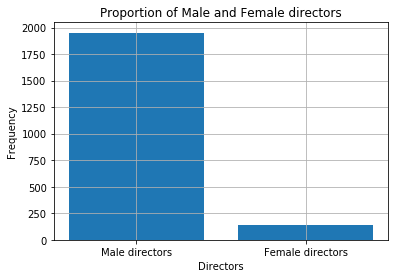

In [48]:
# give the proportion of female and male
female_num = statistical_analyze("nan", "female", "nan", table=comment_frequency, topics_=topics)
male_num = statistical_analyze("nan", "male", "nan", table=comment_frequency, topics_=topics)

label = ["Male directors", "Female directors"]
numbers = [male_num, female_num]
print(numbers)
plot_bar_x(label, numbers, "Proportion of Male and Female directors", "Proportion of Male and Female directors")

[1816, 270]


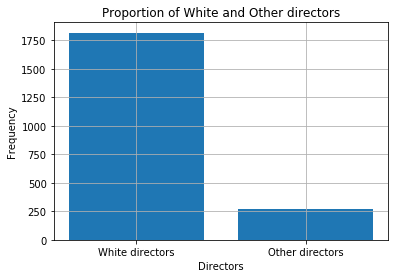

In [49]:
# give the proportion of white and not white
white_num = statistical_analyze("w", "nan", "nan", table=comment_frequency, topics_=topics)
notwhite_num = statistical_analyze("~w", "nan", "nan", table=comment_frequency, topics_=topics)

label = ["White directors", "Other directors"]
numbers = [white_num, notwhite_num]
print(numbers)
plot_bar_x(label, numbers, "Proportion of White and Other directors", "Proportion of White and Other directors")

[1816, 121, 60, 69, 20]


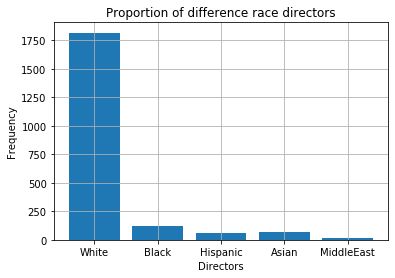

In [53]:
# give the proportion of race
white_num = statistical_analyze("W", "nan", "nan", table=comment_frequency, topics_=topics)
black_num = statistical_analyze("B", "nan", "nan", table=comment_frequency, topics_=topics)
hispanic_num = statistical_analyze("H", "nan", "nan", table=comment_frequency, topics_=topics)
asian_num = statistical_analyze("A", "nan", "nan", table=comment_frequency, topics_=topics)
middle_num = statistical_analyze("M", "nan", "nan", table=comment_frequency, topics_=topics)

label = ["White", "Black", "Hispanic", "Asian", "MiddleEast"]
numbers = [white_num, black_num, hispanic_num, asian_num, middle_num]
print(numbers)
plot_bar_x(label, numbers, "Proportion of difference race directors", "Proportion of difference race directors")

In [71]:
def plot_multiple_bar(bars1_, bars2_, label_list_, group_list_, xlabel_, title_, saveName_, ylabel_="AVG Frequency"):
    # set width of bar
    barWidth = 0.25
    # Set position of bar on X axis
    r1 = np.arange(len(bars1_))
    r2 = [x + barWidth for x in r1]
    # r3 = [x + barWidth for x in r2]
    
    # Make the plot
    plt.bar(r1, bars1_, color='#7f6d5f', width=barWidth, edgecolor='white', label=label_list_[0])
    plt.bar(r2, bars2_, color='#557f2d', width=barWidth, edgecolor='white', label=label_list_[1])
    # plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
    # Add xticks on the middle of the group bars
    plt.xlabel(xlabel_, fontweight='bold')
    plt.ylabel(ylabel_, fontweight='bold')
    plt.title(title_)
    plt.xticks([r + barWidth for r in range(len(bars1_))], group_list_, rotation=20)
    # Create legend & Show graphic
    plt.legend()
    plt.grid()
    plt.savefig("./Save figure/"+ saveName_)
    plt.show()

[21.693175074183976, 14.253412462908011, 8.529376854599407, 4.138278931750742, 5.764985163204748, 6.0308605341246295, 3.948367952522255, 2.893175074183976, 2.2213649851632047, 1.9359050445103858]
[20.7119341563786, 14.893004115226338, 8.555555555555555, 4.292181069958848, 5.604938271604938, 6.152263374485597, 3.860082304526749, 2.921810699588477, 2.1728395061728394, 1.954732510288066]


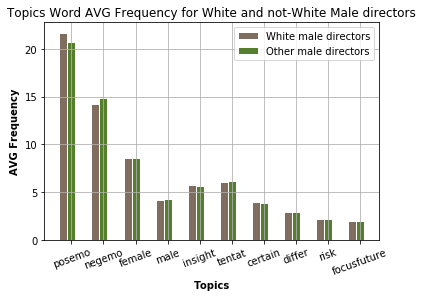

In [74]:
topics = ['posemo', 'negemo', 'female', 'male', 'insight', 'tentat', 'certain', 'differ', 'risk', 'focusfuture']
bar1_list = []
bar2_list = []

for i in range(len(topics)):
    num, fre =  statistical_analyze("W", "male", topics[i], table=comment_frequency, topics_=topics)
    bar1_list.append(fre/num)
    num, fre =  statistical_analyze("~W", "male", topics[i], table=comment_frequency, topics_=topics)
    bar2_list.append(fre/num)

print(bar1_list)
print(bar2_list)
title = "Topics Word AVG Frequency for White and not-White Male directors"
plot_multiple_bar(bar1_list, bar2_list, ["White male directors", "Other male directors"], topics, "Topics", title, title)

[22.3, 13.654545454545454, 8.409090909090908, 4.209090909090909, 5.672727272727273, 5.927272727272728, 3.8727272727272726, 2.518181818181818, 2.090909090909091, 1.6181818181818182]
[21.88, 13.52, 7.28, 3.48, 6.2, 5.48, 4.96, 2.96, 2.2, 1.96]


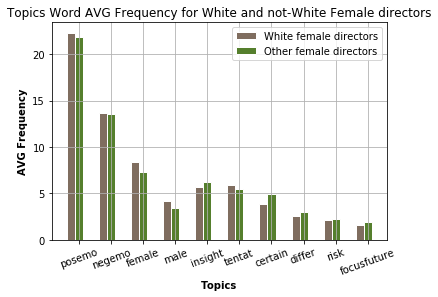

In [75]:
topics = ['posemo', 'negemo', 'female', 'male', 'insight', 'tentat', 'certain', 'differ', 'risk', 'focusfuture']
bar1_list = []
bar2_list = []

for i in range(len(topics)):
    num, fre =  statistical_analyze("W", "female", topics[i], table=comment_frequency, topics_=topics)
    bar1_list.append(fre/num)
    num, fre =  statistical_analyze("~W", "female", topics[i], table=comment_frequency, topics_=topics)
    bar2_list.append(fre/num)

print(bar1_list)
print(bar2_list)
title = "Topics Word AVG Frequency for White and not-White Female directors"
plot_multiple_bar(bar1_list, bar2_list, ["White female directors", "Other female directors"], topics, "Topics", title, title)

[21.730362116991643, 14.216713091922006, 8.522005571030641, 4.142618384401114, 5.75933147632312, 6.024512534818942, 3.943732590529248, 2.8701949860724234, 2.2133704735376045, 1.916434540389972]
[20.82089552238806, 14.764925373134329, 8.436567164179104, 4.2164179104477615, 5.66044776119403, 6.08955223880597, 3.962686567164179, 2.925373134328358, 2.175373134328358, 1.955223880597015]


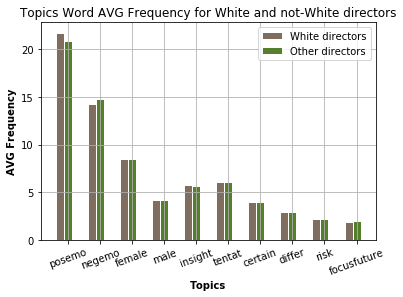

In [76]:
topics = ['posemo', 'negemo', 'female', 'male', 'insight', 'tentat', 'certain', 'differ', 'risk', 'focusfuture']
bar1_list = []
bar2_list = []

for i in range(len(topics)):
    num, fre =  statistical_analyze("W", "nan", topics[i], table=comment_frequency, topics_=topics)
    bar1_list.append(fre/num)
    num, fre =  statistical_analyze("~W", "nan", topics[i], table=comment_frequency, topics_=topics)
    bar2_list.append(fre/num)

print(bar1_list)
print(bar2_list)
title = "Topics Word AVG Frequency for White and not-White directors"
plot_multiple_bar(bar1_list, bar2_list, ["White directors", "Other directors"], topics, "Topics", title, title)

[21.569502074688796, 14.33402489626556, 8.532676348547717, 4.157676348547718, 5.744813278008299, 6.046161825726141, 3.9372406639004147, 2.896784232365145, 2.215248962655602, 1.9382780082987552]
[22.22222222222222, 13.62962962962963, 8.2, 4.074074074074074, 5.770370370370371, 5.844444444444444, 4.074074074074074, 2.6, 2.111111111111111, 1.6814814814814816]


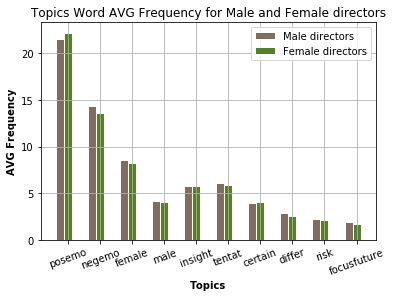

In [77]:
topics = ['posemo', 'negemo', 'female', 'male', 'insight', 'tentat', 'certain', 'differ', 'risk', 'focusfuture']
bar1_list = []
bar2_list = []

for i in range(len(topics)):
    num, fre =  statistical_analyze("nan", "male", topics[i], table=comment_frequency, topics_=topics)
    bar1_list.append(fre/num)
    num, fre =  statistical_analyze("nan", "female", topics[i], table=comment_frequency, topics_=topics)
    bar2_list.append(fre/num)

print(bar1_list)
print(bar2_list)
title = "Topics Word AVG Frequency for Male and Female directors"
plot_multiple_bar(bar1_list, bar2_list, ["Male directors", "Female directors"], topics, "Topics", title, title)

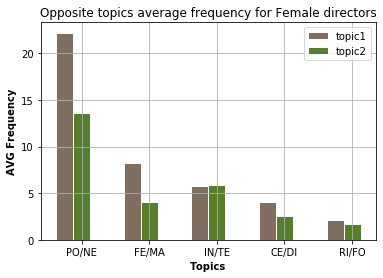

In [55]:
# topics related analysis
# frequency should be based on averaging
# Opposite topics should be put in pairs to compare
# give five pair results based on female

topics = ['posemo', 'negemo', 'female', 'male', 'insight', 'tentat', 'certain', 'differ', 'risk', 'focusfuture']
bar1_list = []
bar2_list = []
for i in range(len(topics)):
    num, fre =  statistical_analyze("nan", "female", topics[i], table=comment_frequency, topics_=topics)
    if i%2 == 0:
        bar1_list.append(fre/num)
    else:
        bar2_list.append(fre/num)

group_list = ["PO/NE", "FE/MA", "IN/TE", "CE/DI", "RI/FO"]
title = "Opposite topics average frequency for Female directors"
plot_multiple_bar(bar1_list, bar2_list, ["topic1", "topic2"], group_list, "Topics", title)

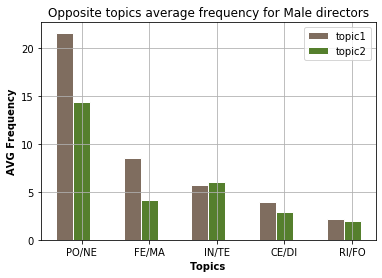

In [15]:
# give five pair results based on male
bar1_list = []
bar2_list = []
for i in range(len(topics)):
    num, fre =  statistical_analyze("nan", "male", topics[i], table=comment_frequency, topics_=topics)
    if i%2 == 0:
        bar1_list.append(fre/num)
    else:
        bar2_list.append(fre/num)

group_list = ["PO/NE", "FE/MA", "IN/TE", "CE/DI", "RI/FO"]
title = "Opposite topics average frequency for Male directors"
plot_multiple_bar(bar1_list, bar2_list, ["topic1", "topic2"], group_list, "Topics", title)

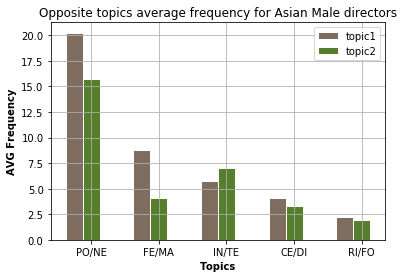

In [16]:
# give five pair results based on race
bar1_list = []
bar2_list = []
for i in range(len(topics)):
    num, fre =  statistical_analyze("A", "male", topics[i], table=comment_frequency, topics_=topics)
    if i%2 == 0:
        bar1_list.append(fre/num)
    else:
        bar2_list.append(fre/num)

group_list = ["PO/NE", "FE/MA", "IN/TE", "CE/DI", "RI/FO"]
title = "Opposite topics average frequency for Asian Male directors"
plot_multiple_bar(bar1_list, bar2_list, ["topic1", "topic2"], group_list, "Topics", title)

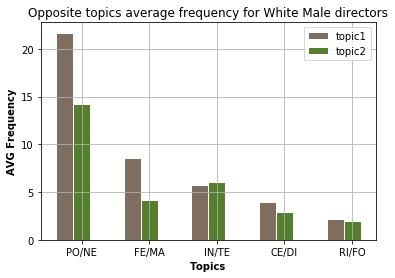

In [17]:
bar1_list = []
bar2_list = []
for i in range(len(topics)):
    num, fre =  statistical_analyze("W", "male", topics[i], table=comment_frequency, topics_=topics)
    if i%2 == 0:
        bar1_list.append(fre/num)
    else:
        bar2_list.append(fre/num)

group_list = ["PO/NE", "FE/MA", "IN/TE", "CE/DI", "RI/FO"]
title = "Opposite topics average frequency for White Male directors"
plot_multiple_bar(bar1_list, bar2_list, ["topic1", "topic2"], group_list, "Topics", title)

## Some problems need to solve at this point:
- Explain code first
- check number of blank directors 
- check number of directors that can not be found in domestic table (300+/2400+)
    - limited sample size for minority people like Hispanic female directors
- To use averaging result or other measures to show more obvious discrepancies
    - if possible, contain more samples. Otherwise, try to give box plot maybe to replace bar plot
- How to define target minority people (combination of gender and race) and topic relevance
- When compared with their sterotype, what their sterotypes are

In [128]:
def statistical_frequency(race_, gender_, topic_, table=comment_frequency, topics_=topics):
    # find subset for minority directors
    # deal with 'W' and 'w' problem here
    if race_ in ["W", "w"]:
        temp_set = table[(table['director_race'] == "W")|(table['director_race'] == "w")]
    # no specific race
    elif race_ == "nan":
        temp_set = table
    # filter out the non-white groups
    elif race_ in["~W", "~w"]:
        temp_set = table[table['director_race'] != "W"]
        temp_set = temp_set[temp_set['director_race'] != "w"]
        temp_set = temp_set[temp_set['director_race'].notnull()]
    else:
        temp_set = table[table['director_race'] == race_]
        
    # filter gender - male or female
    if gender_ == "nan":
        subset = temp_set
    else:
        subset = temp_set[temp_set['director_gender'] == gender_]
    # simply give director proportion analysis
    if topic_ not in topics_:
        return len(subset)
    # find topic index 
    index = topics_.index(topic_)
    
    frequency_list = []
    # use not blank subset to calculate
    subset = subset[subset['critic_comment_topic_frequency'].notnull()]
    total_number = len(subset)
    frequency_result_list = subset['critic_comment_topic_frequency'].to_list()
    for i in range(total_number):
        frequency_string = frequency_result_list[i]
        # total single array for all comments for one director
        frequency_array = getNumbers(frequency_string) 
        frequency = 0
        count = 0
        while count < len(frequency_array)/len(topics_):
            frequency += int(frequency_array[index+count*len(topics_)])
            count += 1
        frequency_list.append(frequency)
    return frequency_list

In [138]:
# define functions to run multiple box plot
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def box_multiple_plot(nested_list_a_, nest_list_b_, ticks_name_, labels_, title_, saveName_):
    plt.figure()
    
    # left box and right box
    bpl = plt.boxplot(nested_list_a_, positions=np.array(range(len(nested_list_a_)))*2.0-0.4, sym='', widths=0.6)
    bpr = plt.boxplot(nest_list_b_, positions=np.array(range(len(nest_list_b_)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    
    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label=labels_[0])
    plt.plot([], c='#2C7BB6', label=labels_[1])
    plt.legend()
    plt.xlabel("Topics", fontweight='bold')
    plt.ylabel("Frequency", fontweight='bold')
    plt.title(title_)
    plt.xticks(range(0, len(ticks_name_) * 2, 2), ticks_name_, rotation=20)
    plt.xlim(-2, len(ticks_name_)*2)
    plt.ylim(-1, 40)
    plt.tight_layout()
    plt.show()
    plt.savefig("./Save figure/"+ saveName_)

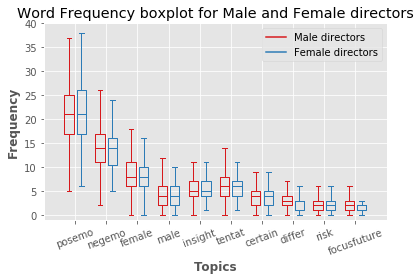

In [141]:
box_list1 = []
box_list2 = []
for i in range(len(topics)):
    fre = statistical_frequency("nan", "male", topics[i], table=comment_frequency, topics_=topics)
    box_list1.append(fre)
    fre = statistical_frequency("nan", "female", topics[i], table=comment_frequency, topics_=topics)
    box_list2.append(fre)

title = "Word Frequency boxplot for Male and Female directors"
box_multiple_plot(box_list1, box_list2, topics, ["Male directors", "Female directors"], title, title)

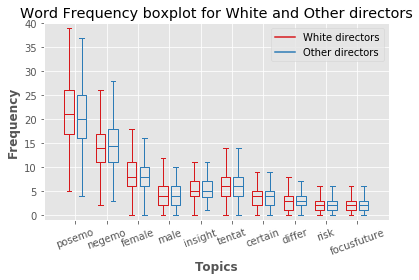

In [142]:
box_list1 = []
box_list2 = []
for i in range(len(topics)):
    fre = statistical_frequency("W", "nan", topics[i], table=comment_frequency, topics_=topics)
    box_list1.append(fre)
    fre = statistical_frequency("~W", "nan", topics[i], table=comment_frequency, topics_=topics)
    box_list2.append(fre)

title = "Word Frequency boxplot for White and Other directors"
box_multiple_plot(box_list1, box_list2, topics, ["White directors", "Other directors"], title, title)